## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti

In [2]:
import numpy as np
import keras
from matplotlib import pyplot as plt
import cv2

Using plaidml.keras.backend backend.


difficulties in executing the next line may lie in `pydot.py` line 117, which can be commented

"`program += extension`" to "`# program += extension`"

models can be saved and loaded via

    model.save("path_to_my_model")
and
    # Recreate the exact same model purely from the file:
    model = keras.models.load_model("path_to_my_model")

Now let's explore some of the data, for starters we will use the following Kaggle dataset: [lego-brick-images](https://www.kaggle.com/joosthazelzet/lego-brick-images)

It's a fairly simple dataset containing renders of some LEGO pieces

In [3]:
os.listdir("../LEGO_brick_images_v1")

['2357 Brick corner 1x2x2',
 '3003 Brick 2x2',
 '3004 Brick 1x2',
 '3005 Brick 1x1',
 '3022 Plate 2x2',
 '3023 Plate 1x2',
 '3024 Plate 1x1',
 '3040 Roof Tile 1x2x45deg',
 '3069 Flat Tile 1x2',
 '3794 Plate 1X2 with 1 Knob']

The first numbers denote the brick model, after that is it's name, size and possible modifications

In [4]:
os.listdir("../LEGO_brick_images_v1/3003 Brick 2x2/")[:10]

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png']

We can see that the folder are filled with individual .png files, these are loadable in Keras.

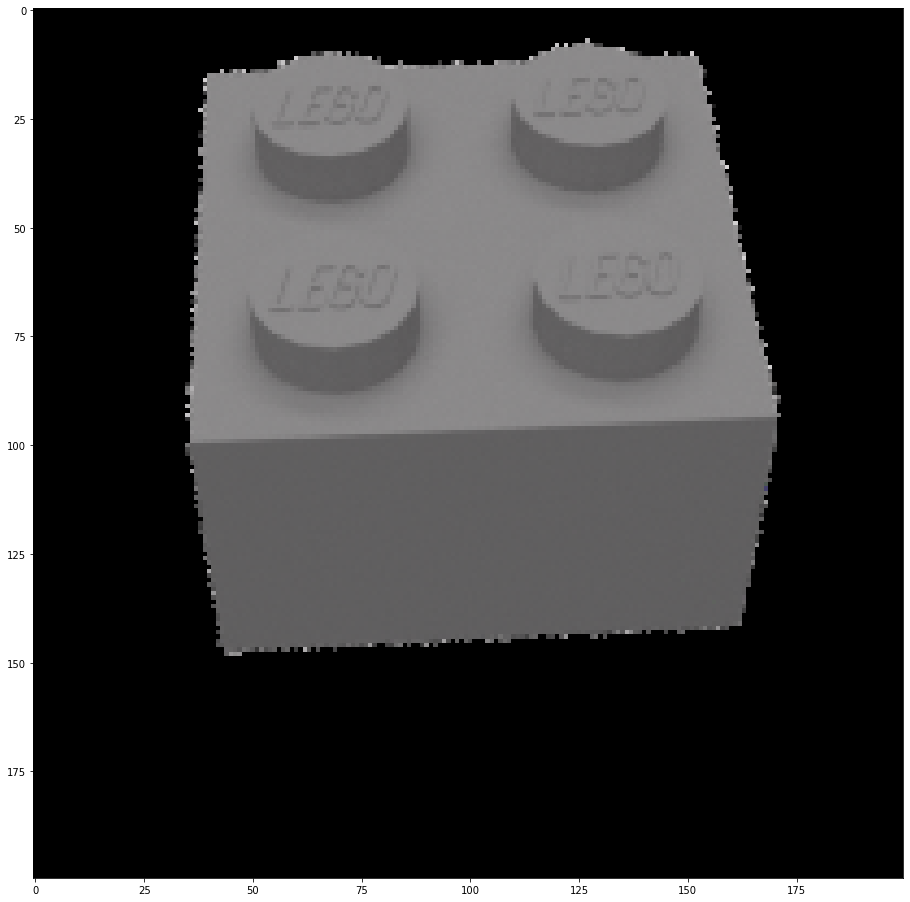

In [5]:
image_path = "../LEGO_brick_images_v1/3003 Brick 2x2/0002.png"
image = cv2.imread(image_path)
plt.figure(figsize=(16,16))
plt.imshow(image)

In [6]:
image.shape

(200, 200, 3)

To try to load the data into Keras, we must first create a subset for training and validation

In [7]:
dataset_path = "../LEGO_brick_images_v1/"
dataset_output = "../output"

In [8]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

from keras.utils import to_categorical

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), target_size=(200,200), shuffle=True, save_to_dir="./test/")
validation_generator = test_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), target_size=(200,200), shuffle=False)

C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\tensorflow\python\framework

Now to declare a model and modify it, we can also use preexisting ones like VGG16 or ResNet

In [12]:
from keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Input, Model

def addLayers(model, filters):
    model.add(Conv2D(filters, (3,3), activation="selu"))
    model.add(SeparableConv2D(filters, (3,3), activation="selu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model = Sequential()
model.add(Lambda(lambda x: x, input_shape=(200, 200, 3)))
addLayers(model, 32)
addLayers(model, 64)
addLayers(model, 128)
addLayers(model, 256)
model.add(Flatten())
model.add(Dense(1024, activation="selu"))
model.add(Dropout(0.5))
model.add(Dense(validation_generator.num_classes, activation="softmax"))

model.summary()

C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\keras\layers\core.py:665: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 200, 200, 3)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 196, 196, 32)      1344      
_________________________________________________________________
batch_normaliza

In [13]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [38]:
from keras.optimizers import Adam,SGD

opt = SGD(lr=0.005,momentum=0.99)
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = 100, 
    validation_data  = validation_generator,
    validation_steps = 100,
    epochs = 20, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
INFO:plaidml:Analyzing Ops: 459 of 735 operations complete
100/100 [==============================] - 82s 816ms/step - loss: 0.3253 - acc: 0.9000 - val_loss: 0.3252 - val_acc: 0.9000

Epoch 00001: val_loss did not improve from 0.32506
Epoch 2/20
100/100 [==============================] - 44s 444ms/step - loss: 0.3253 - acc: 0.9000 - val_loss: 0.3252 - val_acc: 0.9000

Epoch 00002: val_loss did not improve from 0.32506
Epoch 3/20
100/100 [==============================] - 36s 359ms/step - loss: 0.3254 - acc: 0.9000 - val_loss: 0.3252 - val_acc: 0.9000

Epoch 00003: val_loss did not improve from 0.32506
Epoch 4/20
100/100 [==============================] - 35s 352ms/step - loss: 0.3255 - acc: 0.9000 - val_loss: 0.3254 - val_acc: 0.9000

Epoch 00004: val_loss did not improve from 0.32506
Epoch 5/20
100/100 [==============================] - 35s 349ms/step - loss: 0.3254 - acc: 0.9000 - val_loss: 0.3252 - val_acc: 0.9000

Epoch 00005: val_loss did not improve from 0.32506
Epoch 

KeyboardInterrupt: 

In [15]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

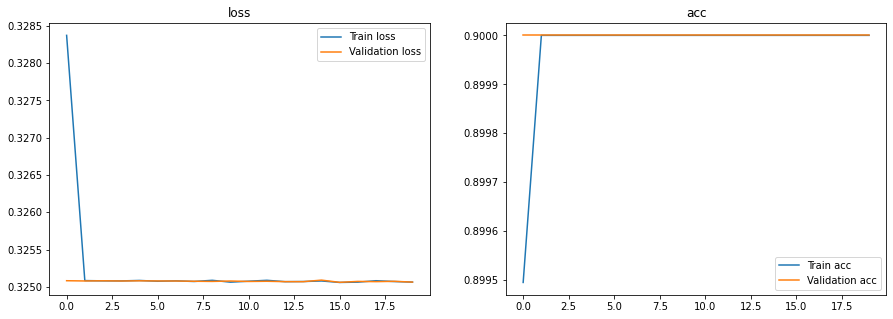

In [16]:
show_final_history(history)